In [2]:
import pyawr.mwoffice as mwo

import numpy as np
from numpy.polynomial.polynomial import polyfit

import matplotlib.pyplot as plt

import qkit.analysis.circle_fit.circle_fit_2019.circuit as cf

#***PICK ONE***
#Agg rendering embedded in a Jupyter widget. (inline) Requires ipympl:
# %matplotlib ipympl 
#Agg rendering to a Tk canvas (new window) Requires TkInter:
# %matplotlib tk 

QKIT configuration initialized -> available as qkit.cfg[...]


In [3]:
awrde = mwo.CMWOffice() #Create awrde object
awrde.Project.Simulator.Analyze() #In/voke circuit simulator analysis

In [4]:
def reset_freqs (l_bnd=4e9, u_bnd=8e9, steps=10000):
    '''Reset the MWO project frequencies.

    returns an array running from 
    lower_bound to upper_bound in steps steps.'''
    
    awrde.Project.Frequencies.Clear() # clear the frequencies specified for the project
    freq_arr = np.linspace(l_bnd, u_bnd, steps)
    awrde.Project.Frequencies.AddMultiple(freq_arr) # add the frequencies in the passed frequency array

    awrde.Project.Simulator.Analyze() # must run this every time after setting or changing things in MWO project!

    return freq_arr

In [5]:
def set_circ_params(circ_name='Sample_Subcircuit', get_params=False, **kwargs): 
    '''Sets specified circuit parameters in circuit called circ_name.
    

    If you attempt to pass a parameter that doesn't exit in the circuit called circ_name, 
    MWO will throw an error.

    Returns a dictionary with the new values.
    '''

    passed_circ_param_vals = { # dictionary of subcircuit element parameter values (e.g. the value of the capacitor (element's) capacitance (parameter.))
        'CAP': awrde.Project.Schematics(circ_name).Elements(1).Parameters(2).ValueAsDouble,
        'IND': awrde.Project.Schematics(circ_name).Elements(2).Parameters(2).ValueAsDouble,
        'RES': awrde.Project.Schematics(circ_name).Elements(3).Parameters(2).ValueAsDouble
    }
    passed_circ_params = { # dictionary of subcircuit component 
        'CAP': awrde.Project.Schematics(circ_name).Elements(1).Parameters(2),
        'IND': awrde.Project.Schematics(circ_name).Elements(2).Parameters(2),
        'RES': awrde.Project.Schematics(circ_name).Elements(3).Parameters(2)
    }

    # print("DEBUG: Setting:" + kwargs.__str__())

    new_circ_param_vals = {**passed_circ_param_vals, **kwargs} # in the case of duplicate keys, only the later key-value pair is preserved
    # print("DEBUG: new parameters:" + new_circ_param_vals.__str__())

    for i, value in enumerate(new_circ_param_vals.values()):
        list(passed_circ_params.values())[i].ValueAsDouble = value # in python3, dict.keys(), .values(), and .items() return dynamically changing view objects, but not the objects themselves. Hence, list().

        # print("DEBUG: " + list(passed_circ_param_vals)[i] + " set to " + str(value))
    
    if not(get_params):
        awrde.Project.Simulator.Analyze() # must run this every time after setting or changing things in MWO project!

    return new_circ_param_vals

In [6]:
def create_polar_graph(schem_name='Hanger_Test'):
    graphs = awrde.Project.Graphs
    # TODO: Name helper graph appropriately
    graph = graphs.Add("CalcHelper {}".format(schem_name), mwo.mwGraphType.mwGT_Polar)

    graph.Measurements.Add(schem_name, 'S(2,1)')

    return graph

In [7]:
def delete_graph(graph=None):
    for i in range(awrde.Project.Graphs.Count):
        if awrde.Project.Graphs.Item(i+1).Name == graph.Name:
            ret = awrde.Project.Graphs.Remove(i+1)

    return ret

In [8]:
def get_meas_vals(graph=None):
    #TODO: iterate over all measurement indicies, add a try-catch for when there's only 1 measurement on the graph
    meas = graph.Measurements[0]

    trace = meas.TraceValues(1)
    freqs, real, imag = zip(*trace)

    return (freqs, real, imag)

In [9]:
def plot_polar(re, im):
    print(re)
    print(im)

    plt.scatter(re, im)

[-0.25238435 -0.25535395 -0.25833989 ...  0.18670062  0.19005536
  0.19337898]
[-0.04826607 -0.04798956 -0.04769268 ...  0.98167067  0.98114889
  0.98060969]


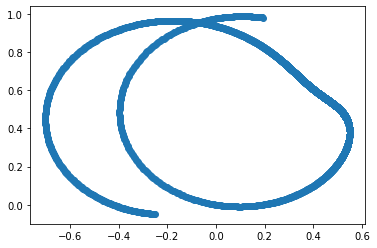

In [14]:
gr = create_polar_graph()
awrde.Project.Simulator.Analyze()
meas_vals = get_meas_vals(gr)
freqs, real, imag = np.asarray(meas_vals)
plot_polar(real, imag)
cpx = real + imag*1j

In [12]:
delete_graph(gr)

NameError: name 'gr' is not defined

In [10]:
def do_stuff():

    gr = create_polar_graph()
    awrde.Project.Simulator.Analyze()
    meas_vals = get_meas_vals(gr)
    freqs, real, imag = np.asarray(meas_vals)
    plot_polar(real, imag)
    cpx = real + imag*1j
    delete_graph(gr)

    circ = cf.reflection_port(freqs, cpx)
    circ.autofit()
    circ.plotall()
    print(circ.fitresults)

    return circ

In [11]:
def is_fit_good(circ):
    fit_good = False

    if circ.Ql>0 and circ.Qc>0 and circ.Qi>0:
        print("Qs all positive.")

        if circ.f_data[0] < circ.fr < circ.f_data[-1]:
            print("fr in f_data")
            fit_good = True
        
        else:
            fit_good = False

    else:
        fit_good = False
    
    return fit_good

[-0.25238435 -0.25357035 -0.25475896 ...  0.1907223   0.19205312
  0.19337898]
[-0.04826607 -0.04815787 -0.04804646 ...  0.98104247  0.98082745
  0.98060969]


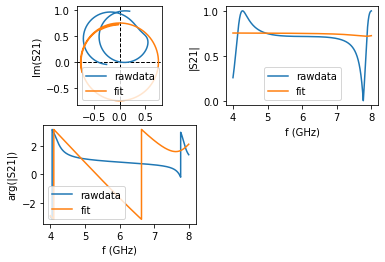

{'delay': 4.1701027952414367e-10, 'delay_remaining': -3.0356843047994053e-10, 'a': 0.757009560729148, 'alpha': 1.1133951628671928, 'theta': -2.005953496161716, 'phi': 0.022243994560884328, 'fr': 8015753022.841413, 'Ql': -9.882035005880082, 'Qc': -10.099875749463498, 'Qc_no_dia_corr': -10.097377166994416, 'Qi': -458.16647551526245, 'Qi_no_dia_corr': -463.36785195925717, 'fr_err': 25569922.7202689, 'Ql_err': 0.7712026776601163, 'absQc_err': 0.5515113433293835, 'phi_err': 0.05284110006936088, 'Qi_err': 1068.2615800962737, 'Qi_no_dia_corr_err': 1110.7714900345798, 'chi_square': 1.5482797452785555}
[0.16117926 0.16121555 0.1612518  ... 0.64938248 0.64942728 0.64947206]
[0.24378899 0.24375967 0.24373026 ... 0.60100812 0.60094112 0.60087417]


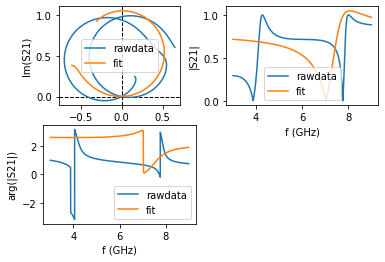

{'delay': 6.890119042491476e-12, 'delay_remaining': 2.856195558889855e-10, 'a': 0.7985812742132636, 'alpha': 2.5994029936119314, 'theta': 0.16298315354234827, 'phi': 0.7051728135202104, 'fr': 7467600514.347652, 'Ql': -7.2904100813589405, 'Qc': -14.619021447623618, 'Qc_no_dia_corr': -11.132378274020079, 'Qi': -14.542818006691482, 'Qi_no_dia_corr': -21.12448586988485, 'fr_err': 25746628.859748587, 'Ql_err': 0.3197392673206256, 'absQc_err': 0.5188948097754496, 'phi_err': 0.034271167986307666, 'Qi_err': 1.1160446510450757, 'Qi_no_dia_corr_err': 2.2834858892004952, 'chi_square': 1.0375532045791611}
[0.17281997 0.17281594 0.17281189 ... 0.35041909 0.35044837 0.35047764]
[0.19944643 0.19941498 0.19938351 ... 0.65924214 0.6592075  0.65917287]


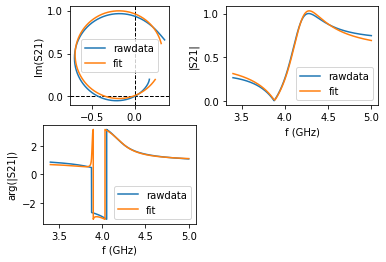

{'delay': -6.639542331015757e-13, 'delay_remaining': -1.2998470633071191e-11, 'a': 0.5169574893606739, 'alpha': 0.8791877408392736, 'theta': 2.962208357564176, 'phi': -1.0585720368648905, 'fr': 4180978399.8469367, 'Ql': 12.043265096478402, 'Qc': 24.83745455924965, 'Qc_no_dia_corr': 12.173265533660878, 'Qi': 23.37967953727557, 'Qi_no_dia_corr': 1127.7336222024874, 'fr_err': 438317.0230259099, 'Ql_err': 0.022808067713097832, 'absQc_err': 0.019460495540704073, 'phi_err': 0.0011691329958567443, 'Qi_err': 0.07542377664675821, 'Qi_no_dia_corr_err': 101.17262358053723, 'chi_square': 0.00429608286306361}
Qs all positive.
fr in f_data
[0.54264555 0.54265294 0.54266032 ... 0.61094896 0.61097    0.61099103]
[0.42960534 0.42957563 0.42954591 ... 0.66208883 0.66205455 0.66202027]


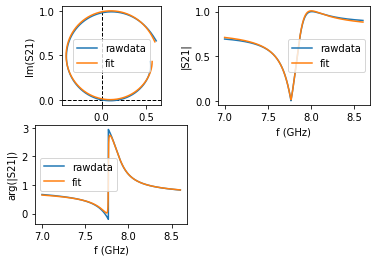

{'delay': 9.916192684202838e-12, 'delay_remaining': -1.9495855988602888e-12, 'a': 0.7983297889664458, 'alpha': 1.2160481269703982, 'theta': -2.591680092207442, 'phi': -0.6661355655880472, 'fr': 7855427496.302183, 'Ql': 34.49992922396244, 'Qc': 70.26384098573112, 'Qc_no_dia_corr': 55.242525565716114, 'Qi': 67.78054808878079, 'Qi_no_dia_corr': 91.88161360175276, 'fr_err': 171950.7997229628, 'Ql_err': 0.036411070220282823, 'absQc_err': 0.05477451556936671, 'phi_err': 0.00039614020477472367, 'Qi_err': 0.08467197260962313, 'Qi_no_dia_corr_err': 0.12578378102220567, 'chi_square': 0.0001927640441375987}
Qs all positive.
fr in f_data


True

In [28]:
reset_freqs()
ds = do_stuff()
is_fit_good(ds)

reset_freqs(3e9, 9e9, 10000)
ds = do_stuff()
is_fit_good(ds)

reset_freqs(3.4e9, 5e9, 10000)
ds = do_stuff()
is_fit_good(ds)

reset_freqs(7e9, 8.6e9, 10000)
ds = do_stuff()
is_fit_good(ds)


In [29]:
from sympy import Symbol, diff, exp, cos, pi, lambdify

class analyze_circuit(cf.circuit):

    n_ports = None
    f_data = None

    def __init__(self, circ):
        self.n_ports = circ.n_ports
        self.f_data = circ.f_data
        print(self.n_ports.__str__() + " ports")

    def max_deriv_Sij_freq(self, fr, Ql, Qc, phi=0., a=1., alpha=0., delay=0.):
        '''
        Returns the frequency at which the magnitude of the derivative of Sij is maximized.
        '''
        print(self.n_ports)
        f = Symbol('f', real=True)

        complexQc = Qc*cos(phi)*exp(-1j*phi)

        print('qc is ' + complexQc.__str__())

        print('pt 1: ' + (a*exp(1j*(alpha-2*pi*f*delay))).__str__())
        print('pt 2: ' + (self.n_ports).__str__())

        S = a*exp(1j*(alpha-2*pi*f*delay)) * (
            1. - 2.*Ql / (complexQc * self.n_ports * (1. + 2j*Ql*(f/fr-1.)))
        )

        ds = diff(S, f)
        ds_np = lambdify(f, ds, 'numpy')
        #NOTE: I'm just maximizing the magnititude of the derivatives of Sij here... Complex numbers have no ordering
        ds_mags = np.asarray(np.abs(ds_np(self.f_data)))
        arg = np.argmax(ds_mags)

        return self.f_data[arg]




In [27]:
new_circ = analyze_circuit(ds)
print(ds.fr, ds.Ql, ds.Qc, ds.phi, ds.a, ds.alpha, ds.delay)
max = new_circ.max_deriv_Sij_freq(ds.fr, ds.Ql, ds.Qc, ds.phi, ds.a, ds.alpha, ds.delay)
print(max)

1.0 ports
7855427496.302183 34.49992922396244 70.26384098573112 -0.6661355655880472 0.7983297889664458 1.2160481269703982 9.916192684202838e-12
1.0
qc is 55.2425255657161*exp(0.666135565588047*I)
pt 1: 0.798329788966446*exp(1.0*I*(-1.98323853684057e-11*pi*f + 1.2160481269704))
pt 2: 1.0
7855765576.557655
